# Analysis of Internet Quality in a University Campus

#### **Understanding the problem**
The students of Airforce Institute of Technology are being haunted by a very discouraging internet connectivity problem, it has lead to a very poor student experience overall because it makes the students have to account for the best workaround or trade-off for their poor network before carrying out any activities which is very time comsuming and hinders their productivity.

#### **Objectives**
- Clean and normalize the data loaded into the SQLite database from the ETL pipeline that was setup.
- Perform EDA on the data, to identify potential inconsistencies and to gain better insights on the survey.
- Identify which key factors contribute the most to the `campus_internet_satisfaction` feature
- Use the identified factors to investigate what the true cause of poor internet on campus is.
- Use generatve AI and/or NLP to analyze `suggestions_for_improvement` to know what students believe will solve the issue.
- Use Machine Learning to predict what the satisfaction level of a new student would most likely be.
- Build a dashboard that expresses all the key factors contributing to internet satisfaction.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
sns.set_style("whitegrid")

In [2]:
conn = sqlite3.connect("survey_data.db")

# Create a DataFrame from the "survey_responses" table
data = pd.read_sql_query("SELECT * FROM survey_responses", conn)

conn.close()

## Data Cleaning and Normalization

In [3]:
data["timestamp"] = pd.to_datetime(data["timestamp"])

def clean_data(data):
    # Replace missing values with "Graduate" in column: 'school_year'
    data = data.fillna({'school_year': "Graduate"})
    # Replace missing values with "No Faculty" in column: 'program_faculty'
    data = data.fillna({'program_faculty': "No Faculty"})
    # Remove leading and trailing whitespace in column: 'most_used_device'
    data['most_used_device'] = data['most_used_device'].str.strip()
    # Replace all instances of "phone and laptop" with "Phone" in column: 'most_used_device'
    data.loc[data['most_used_device'].str.lower() == "phone and laptop".lower(), 'most_used_device'] = "Phone"
    # Remove leading and trailing whitespace in column: 'most_time_spent_on'
    data['most_time_spent_on'] = data['most_time_spent_on'].str.strip()
    # Replace missing values with "None" in column: 'most_time_spent_on'
    data = data.fillna({'most_time_spent_on': "None"})
    # Replace missing values with "None" in column: 'suggestions_for_improvement'
    data = data.fillna({'suggestions_for_improvement': "None"})
    return data

data = clean_data(data.copy())
data

,timestamp,gender,school_year,program_faculty,residence,most_used_device,most_time_spent_on,daily_online_time_on_campus,most_active_time_on_campus,primary_internet_providers,...,mtn_experience_rating,airtel_experience_rating,glo_experience_rating,nine_mobile_experience_rating,afit_cict_experience_rating,poor_service_coping_methods,academic_impact_of_poor_internet,financial_impact_of_poor_internet,planning_to_switch_provider,suggestions_for_improvement
0,2025-02-13 01:39:04,Male,400L,Faculty of Ground and Communications Engineering,School Hostel,Laptop,"Video Streaming, Socials, Messaging",5 - 8 hours,After Dark (12am - 5am),"Airtel, AFIT CICT",...,2.0,3.0,0.0,0.0,3.0,"Using multiple providers, Changing location wh...",Yes,Yes,Maybe,None
1,2025-02-13 01:44:37,Male,400L,Faculty of Air Engineering,Barkallahu,Phone,Socials,3 -5 hours,Afternoon,"MTN, Airtel, GLO",...,1.0,1.0,3.0,0.0,2.0,Using multiple providers,Yes,No,Yes,None
2,2025-02-13 01:52:48,Male,400L,Faculty of Ground and Communications Engineering,Barkallahu,Phone,"Video Streaming, Socials, Productivity/Work",Less than 1 hour,Evening,MTN,...,2.0,0.0,0.0,0.0,2.0,"Changing location when in need of internet, Re...",No,No,No,None
3,2025-02-13 01:58:11,Male,400L,Faculty of Ground and Communications Engineering,Barkallahu,Phone,"Socials, Messaging, Productivity/Work",Less than 1 hour,Afternoon,"MTN, Airtel, GLO",...,1.0,2.0,3.0,0.0,2.0,"Using multiple providers, Changing location wh...",No,Yes,Maybe,"Disable the ""scramblers"" if there are or find ..."
4,2025-02-13 02:01:31,Male,400L,Faculty of Ground and Communications Engineering,Barkallahu,Phone,"Video Streaming, Messaging, Productivity/Work",3 -5 hours,Afternoon,"MTN, Airtel, AFIT CICT",...,1.0,1.0,0.0,0.0,1.0,Using multiple providers,Yes,Yes,No,Better WiFi and service provider connectivity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,2025-03-04 23:27:34,Female,400L,Faculty of Science,School Hostel,Phone,Socials,1 - 3 hours,Night,"MTN, Airtel",...,2.0,3.0,0.0,0.0,2.0,Changing location when in need of internet,No,No,Maybe,None
323,2025-03-05 12:27:37,Male,100L,Faculty of Ground and Communications Engineering,School Hostel,Phone,"Socials, Messaging, Productivity/Work",3 -5 hours,Afternoon,"MTN, Airtel",...,1.0,1.0,0.0,0.0,0.0,"Using multiple providers, Changing location wh...",No,Yes,No,None
324,2025-03-09 23:21:48,Male,400L,Faculty of Science,School Hostel,Phone,"Movie & TV downloads, Messaging, Readable content",1 - 3 hours,Afternoon,"MTN, GLO, AFIT CICT",...,1.0,2.0,2.0,3.0,2.0,"Changing location when in need of internet, Re...",Yes,No,Yes,None
325,2025-03-15 11:36:58,Male,300L,Faculty of Computing,School Hostel,Phone,"Messaging, Productivity/Work, Readable content",3 -5 hours,After Dark (12am - 5am),"MTN, Airtel, AFIT CICT",...,3.0,3.0,0.0,0.0,4.0,"Using multiple providers, Staying awake midnig...",Yes,Yes,No,AFIT should provide more Wifi with higher freq...


## Exploratory Data Analysis

In [4]:
data.columns

Index(['timestamp', 'gender', 'school_year', 'program_faculty', 'residence',
       'most_used_device', 'most_time_spent_on', 'daily_online_time_on_campus',
       'most_active_time_on_campus', 'primary_internet_providers',
       'internet_provider_choice_factors', 'monthly_internet_spend',
       'monthly_data_usage_gb', 'campus_internet_satisfaction',
       'internet_issues_frequency', 'main_internet_issues',
       'mtn_experience_rating', 'airtel_experience_rating',
       'glo_experience_rating', 'nine_mobile_experience_rating',
       'afit_cict_experience_rating', 'poor_service_coping_methods',
       'academic_impact_of_poor_internet', 'financial_impact_of_poor_internet',
       'planning_to_switch_provider', 'suggestions_for_improvement'],
      dtype='object')

#### **Focus Points**
1. Internet Providers
2. Location
3. Time of Day
4. Activity



#### **Internet Providers**

First let's understand which services are providing the service in the first place, and see how satisfied their users are.

In [5]:
provider_user_count = data["primary_internet_providers"].str.split(', ').explode().value_counts()
provider_user_count_sum = provider_user_count.sum()

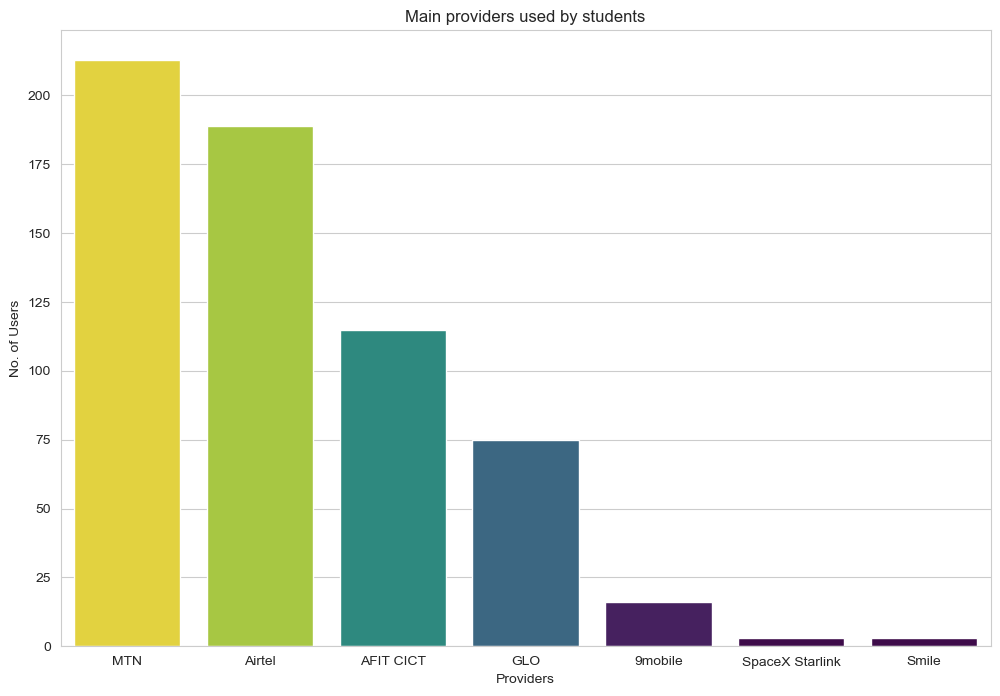

In [6]:
plt.figure(figsize=(12, 8))
sns.barplot(x=provider_user_count.index, y=provider_user_count.values, palette="viridis", hue=provider_user_count.values, legend=False)
plt.title("Main providers used by students")
plt.xlabel("Providers")
plt.ylabel("No. of Users")
plt.show()

This shows that most students are MTN users, with Airtel following very closely.
The schools own internet service comes in at third showing a good amount of students depend on it for internet.

In [7]:
satisfaction_mapping = {
    "Very Dissatisfied": 1,
    "Dissatisfied": 2,
    "Neutral": 3,
    "Satisfied": 4,
    "Very Satisfied": 5
}

data["satisfaction_numeric"] = data["campus_internet_satisfaction"].map(satisfaction_mapping)

all_providers = ["Airtel", "MTN", "GLO", "AFIT CICT", "Smile", "9mobile", "SpaceX Starlink"]

provider_satisfaction = {provider: [] for provider in all_providers}

for i, row in data.iterrows():
    providers = [p.strip() for p in row["primary_internet_providers"].split(",")]
    satisfaction_score = row["satisfaction_numeric"]
    for provider in providers:
        if provider in provider_satisfaction:
            provider_satisfaction[provider].append(satisfaction_score)

average_provider_satisfaction = {provider: round(np.mean(scores), 2) if scores else None for provider, scores in provider_satisfaction.items()}
average_provider_satisfaction

{'Airtel': 1.85,
 'MTN': 1.77,
 'GLO': 2.05,
 'AFIT CICT': 2.03,
 'Smile': 2.0,
 '9mobile': 1.94,
 'SpaceX Starlink': 3.0}

In [8]:
provider_satisfaction["SpaceX Starlink"]

[5, 1, 3]

In [9]:
list(average_provider_satisfaction.items())

[('Airtel', 1.85),
 ('MTN', 1.77),
 ('GLO', 2.05),
 ('AFIT CICT', 2.03),
 ('Smile', 2.0),
 ('9mobile', 1.94),
 ('SpaceX Starlink', 3.0)]

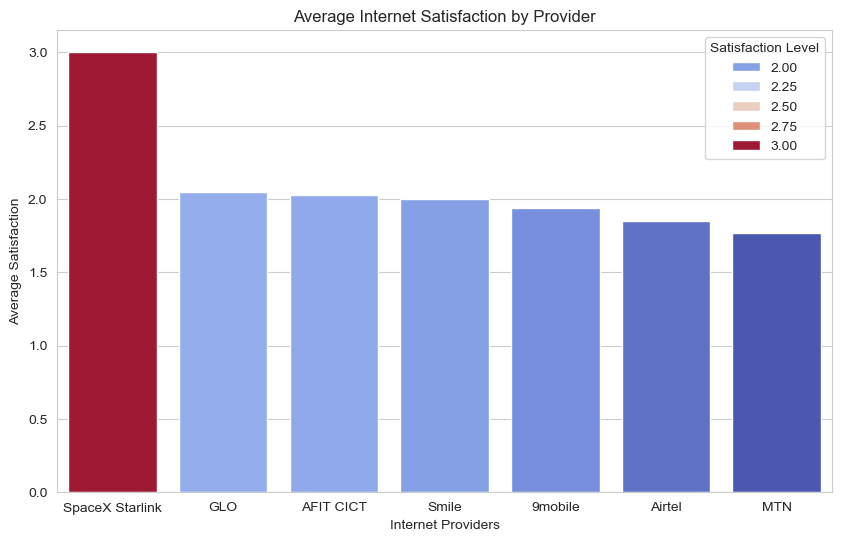

In [10]:
average_satisfaction_df = pd.DataFrame(list(average_provider_satisfaction.items()), 
                                       columns=["Provider", "Average Satisfaction"]).dropna()

average_satisfaction_df = average_satisfaction_df.sort_values(by="Average Satisfaction", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_satisfaction_df["Provider"], y=average_satisfaction_df["Average Satisfaction"], palette="coolwarm", hue=average_satisfaction_df["Average Satisfaction"])
plt.xlabel("Internet Providers")
plt.ylabel("Average Satisfaction")
plt.title("Average Internet Satisfaction by Provider")
plt.legend(title="Satisfaction Level")
plt.show()

Starlink users seem to have the highest internet satifaction, though there are no students bringing their starlink units to use on campus, GLO and AFIT CICT (which is the schools own internet service) have the most satisfied users.
Oddly the two most used providers by students seem to have the lowest average satisfaction with MTN being the least.

Now lets see the percentage of students that are planning on switching providers

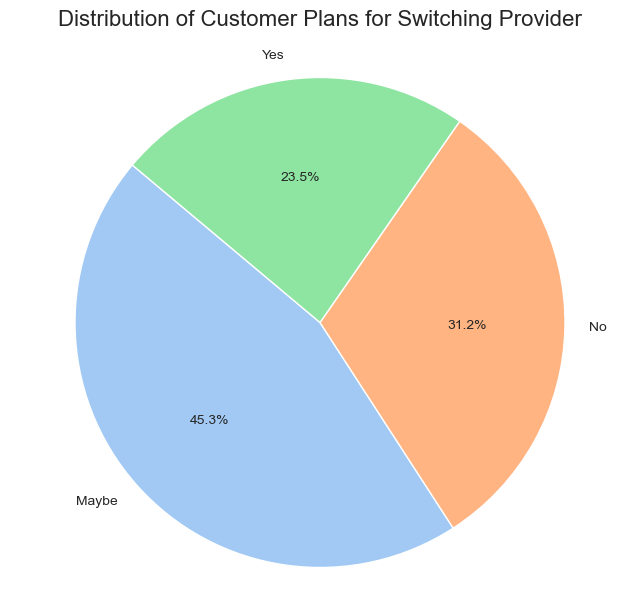

In [11]:
plan_to_switch_provider = data["planning_to_switch_provider"].value_counts()

plt.figure(figsize=(8, 7))
plt.pie(plan_to_switch_provider, labels=plan_to_switch_provider.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Customer Plans for Switching Provider', fontsize=16, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart shows that 45% of the students that filled the survey are considering switching providers due to to dissatisfaction. And 23.5% of them already have this plan in motion.

Let's see exactly which providers will be affected the most by this.

In [12]:
provider_churn = {provider: [] for provider in all_providers}

# Iterate through the dataframe to extract churn status for each provider
for i, row in data.iterrows():
    providers = [p.strip() for p in row["primary_internet_providers"].split(",")]
    churn_status = row["planning_to_switch_provider"]
    for provider in providers:
        if provider in provider_churn:
            provider_churn[provider].append(churn_status)

print(provider_churn) 

{'Airtel': ['Maybe', 'Yes', 'Maybe', 'No', 'Yes', 'No', 'Maybe', 'No', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'No', 'Yes', 'No', 'Maybe', 'Yes', 'Maybe', 'No', 'No', 'Maybe', 'Yes', 'Maybe', 'No', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'No', 'Maybe', 'Yes', 'Maybe', 'No', 'Maybe', 'Maybe', 'No', 'No', 'No', 'No', 'Maybe', 'Maybe', 'No', 'No', 'Yes', 'No', 'Maybe', 'Maybe', 'Yes', 'Yes', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'Yes', 'Maybe', 'Maybe', 'No', 'Maybe', 'Yes', 'Yes', 'Maybe', 'Maybe', 'No', 'No', 'No', 'No', 'Yes', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'No', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'Maybe', 'No', 'Maybe', 'Maybe', 'Yes', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'Maybe', 'Maybe', 'No', 'Maybe', 'No', 'Maybe', 'Yes', 'No', 'Maybe', 'Maybe', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'No', 'Yes', 'No', 'Maybe', 'No', 'Maybe', 'Maybe', 'Maybe', 'Maybe', 'Yes', 'No', 'No', 'Maybe', 'Maybe', 'No', 'Maybe', 'No', 'No', 'No

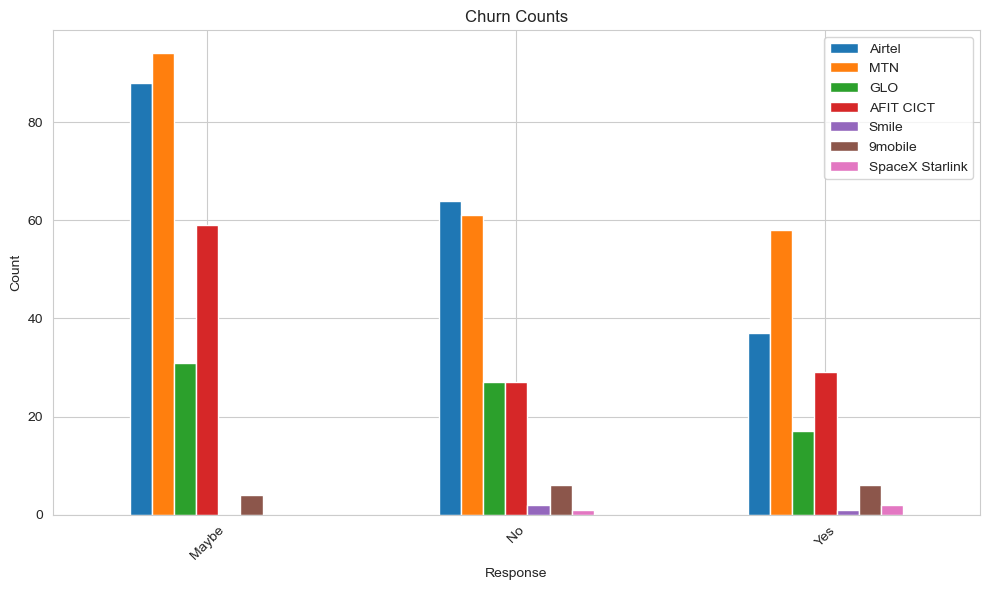

In [13]:
# Convert the provider churn dictionary to a dataframe
provider_churn_df = pd.DataFrame.from_dict(provider_churn, orient='index').transpose()

# Create a collection of barcharts for each providers churn counts
provider_churn_df

provider_churn_counts = provider_churn_df.apply(lambda x: x.value_counts()).fillna(0)

provider_churn_counts.plot(kind='bar', figsize=(10, 6), title=f"Churn Counts")
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart shows that MTN and Airtel are the most affected by user churn. Although this might be due to the fact that they have more customers in general. AFIT CICT also have a high level of people that want to stop using it which might mean there's also a difficulties expericenced when using the schools Wi-Fi 

Now lets understand the experience of the users for each carrier

In [14]:
provider_experience_df = data[["mtn_experience_rating", "airtel_experience_rating", "glo_experience_rating", "afit_cict_experience_rating", "nine_mobile_experience_rating"]]

provider_experience_df = provider_experience_df.rename(columns={
    "mtn_experience_rating": "MTN",
    "airtel_experience_rating": "Airtel",
    "glo_experience_rating": "GLO",
    "afit_cict_experience_rating": "AFIT CICT",
    "nine_mobile_experience_rating": "9mobile"
})

<Axes: >

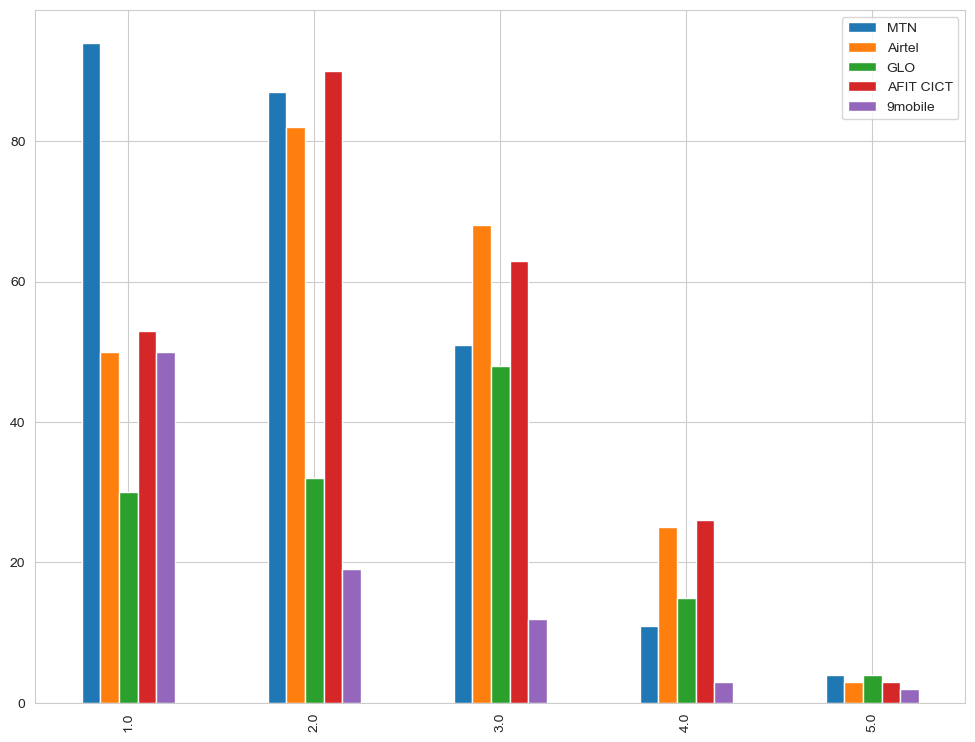

In [15]:
provider_experience_counts = provider_experience_df.apply(lambda x: x.value_counts())

provider_experience_counts = provider_experience_counts.drop(0.0)
provider_experience_counts.plot(kind="bar", figsize=(12, 9))

In [16]:
# Prepare data for Plotly
ratings = provider_experience_counts.index.tolist()
providers = provider_experience_counts.columns.tolist()

fig = go.Figure()

for provider in providers:
    fig.add_trace(go.Bar(x=ratings, y=provider_experience_counts[provider], name=provider,
                         hovertemplate=f'Network: {provider}<br>: %{{y}}<extra></extra>'))

fig.update_layout(
    title='Provider Experience Ratings',
    xaxis_title='Rating',
    yaxis_title='Count',
    legend_title='Mobile Network Provider',
    barmode='group' # To show bars side by side for different providers
)

iplot(fig)

This chart shows that very few students reported top tier ratings (4 and 5), while a majority of them gave lower ratings (1 and 2). Students ratings are generally skewed to the lower end meaning there is a horrible experience with network providers across board.

##### **Final Thoughts on Internet Providers**

Given the fact that MTN and Airtel are the most used providers on campus and there is general dissatisfaction with the quality of internet from them, also the fact that their internet experience is rated poorly, the overall poor experience is coming from them. 
AFIT CICT also shows sub-optimal internet performance across all metrics, which means the quality of the internet provided by the school is very poor.

#### **Location**

First let's see where students are living either on or off campus

In [17]:
data["residence"].value_counts()

residence
School Hostel             147
Barkallahu                 87
Commute within Kaduna      33
Airforce Base              21
Agric Quarters             15
Mando                      10
Kawo                        8
Commute outside Kaduna      6
Name: count, dtype: int64

In [18]:
def campus_identifier(resid):
    if resid == "School Hostel":
        return "On Campus"
    else:
        return "Off Campus"
    
data["campus_status"] = data["residence"].apply(campus_identifier)
campus_status = data["campus_status"].value_counts()


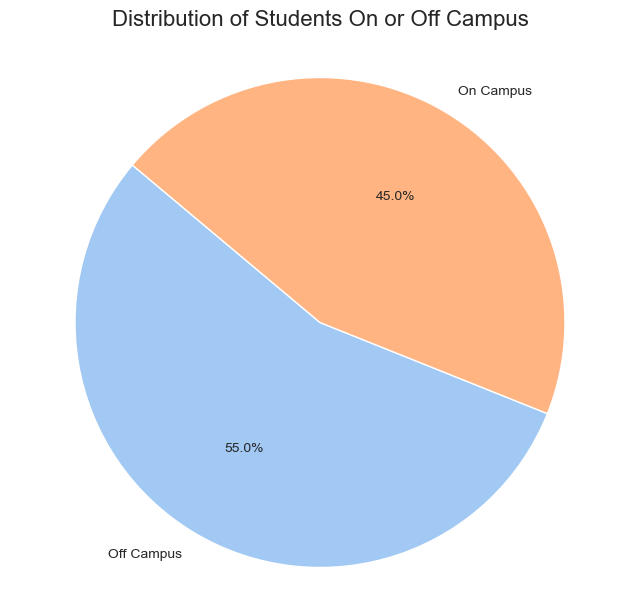

In [19]:
plt.figure(figsize=(8, 7))
plt.pie(campus_status, labels=campus_status.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Students On or Off Campus', fontsize=16, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Now let's start with how frequently students run into internet issues

<Axes: title={'center': 'Internet Issues Frequency by Campus Status'}, xlabel='internet_issues_frequency'>

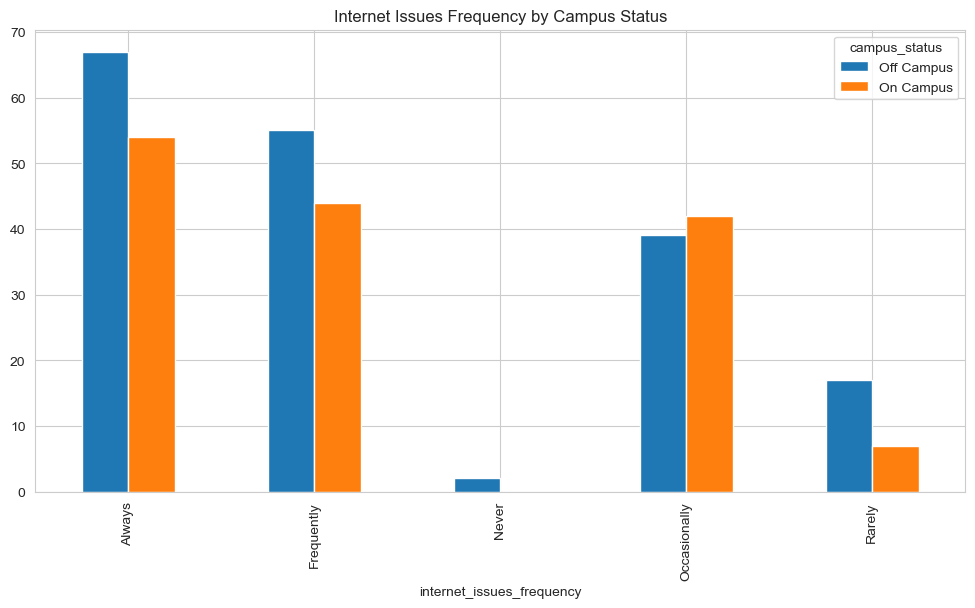

In [20]:
campus_satisfaction_grouping = data[["campus_status", "internet_issues_frequency"]].groupby("internet_issues_frequency").value_counts()
campus_satisfaction_grouping = campus_satisfaction_grouping.unstack().fillna(0.0)
campus_satisfaction_grouping.plot(kind="bar", figsize=(12, 6), title="Internet Issues Frequency by Campus Status")

In [21]:
# data[["campus_status", "main_internet_issues"]]

main_internet_issues = list(data["main_internet_issues"].str.split(", ").explode().unique())

main_issues_count_list = []
for issue in main_internet_issues:
    issue_value_counts = data["campus_status"][data["main_internet_issues"].str.contains(issue)].value_counts()
    for campus, count in issue_value_counts.items():
        main_issues_count_list.append({'Issue': issue, 'Campus': campus, 'Count': count})

main_issues_by_campus_df = pd.DataFrame(main_issues_count_list)

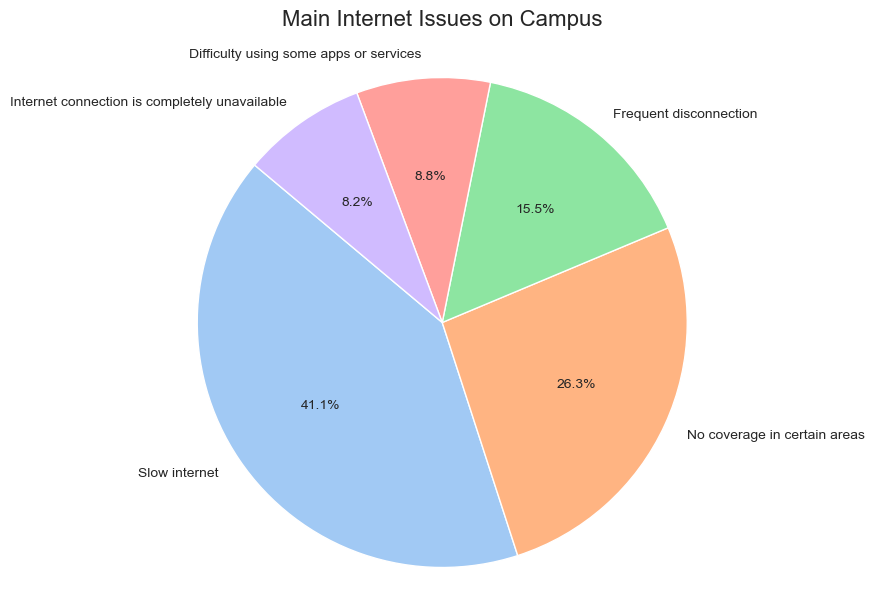

In [31]:
main_internet_issues_counts = data["main_internet_issues"].str.split(", ").explode().value_counts()

plt.figure(figsize=(8, 7))
plt.pie(main_internet_issues_counts, labels=main_internet_issues_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Main Internet Issues on Campus', fontsize=16, pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

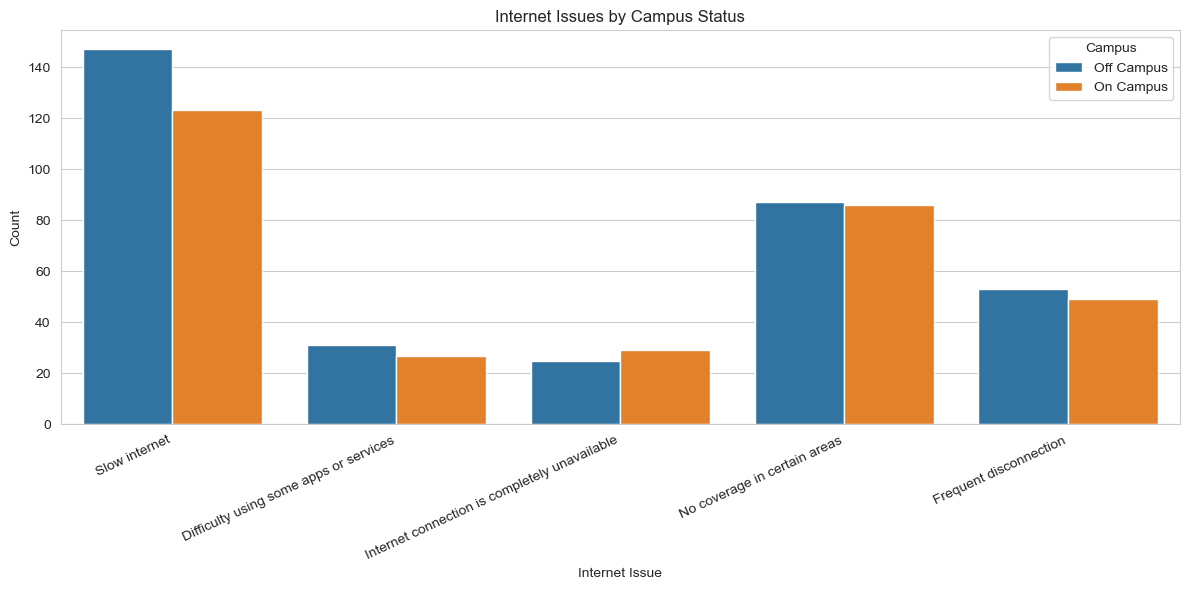

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(data=main_issues_by_campus_df, x='Issue', y='Count', hue='Campus')
plt.title('Internet Issues by Campus Status')
plt.xlabel('Internet Issue')
plt.ylabel('Count')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Getting the individual values in the "most_time_spent_on" column
exploded_most_time_spent_on = data["most_time_spent_on"].str.split(', ').explode()
exploded_most_time_spent_on = exploded_most_time_spent_on.str.strip(",").str.strip() # Remove leading and trailing commas and whitespaces
time_on_activity_count = exploded_most_time_spent_on.value_counts().head(8)
time_on_activity_count 

most_time_spent_on
Productivity/Work               190
Socials                         179
Messaging                       127
Readable content                120
Movie & TV downloads             75
Audio streaming or downloads     65
Video Streaming                  64
Gaming                           49
Name: count, dtype: int64

<Axes: ylabel='most_time_spent_on'>

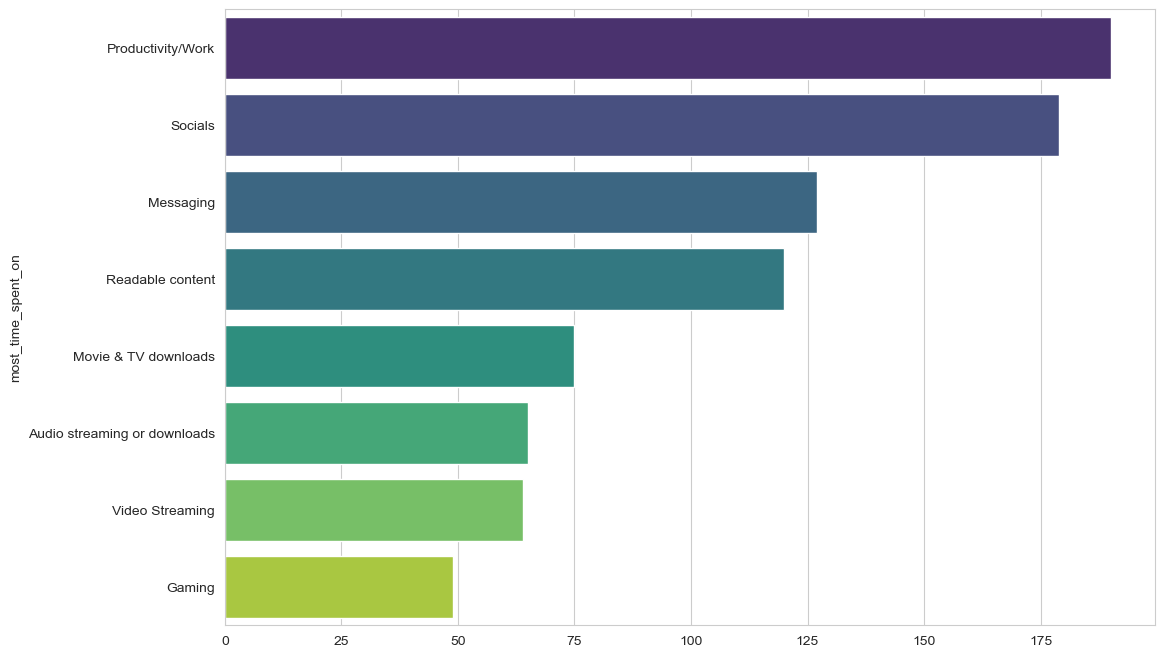

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=time_on_activity_count.values, y=time_on_activity_count.index, palette="viridis", hue=time_on_activity_count.index, legend=False)